In [1]:
import os
# os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin") # path to nvidia dlls, must have CUDA drivers installed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

### GPU Acceleration

** IMPORTANT NOTE **
 - You must have CUDA driver and CUDA toolkit installed on your machine. To do so, follow the instructions here:
https://www.tensorflow.org/install/pip

- Enable GPU Acceleration if you have a NVIDIA GPU with compute capability >= 7.0

In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

# ## ENABLE THIS IF YOU HAVE RTX GPU WITH COMPUTE CAPABILITY 7.0 or higher
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### Loading Data

In [3]:
fp = "../data/features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()
dataset.sort_values(by=['policy'], ascending=True, inplace=True)

# dataset
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])

### Test run setup
1. Adjust global model config to test the model settings
2. Change the Run configuration to define the saved location for the results and the number of runs
3. Run the notebook
4. Clear output and restart the notebook for the next run.

In [4]:
## Global Model Config
EPOCHS = 2500
UNITS = 1
LEARNING_RATE = 0.01
CALLBACK = tf.keras.callbacks.EarlyStopping(monitor='RMSE', patience=15, min_delta=0.01)

#### Run configuration

In [5]:
## Define the run setup

RUN_NUMBER = 5 # Test run number
SAVED_RESULT_PATH = "../variance_model/results/test_run#" + str(RUN_NUMBER) # path to saved results

if ( os.path.exists(SAVED_RESULT_PATH) ):
    print("Directory " , SAVED_RESULT_PATH , " already exists")
else:
    os.mkdir(SAVED_RESULT_PATH)
    print("Directory " , SAVED_RESULT_PATH , " created")

Directory  ../variance_model/results/test_run#5  created


## Data split
Split by policy fast charge first(5C - 8C), and then by policy slow charge (1C - 4C)


In [6]:
fast_charge_dataset = dataset.iloc[29:, :] 
print(fast_charge_dataset.shape) # 51 data points 

(51, 15)


## Fast-Charge Test-Train split
Selecting alternate batteries for training and testing

In [7]:
fast_charge_train_ds = fast_charge_dataset.iloc[0::2, :]
fast_charge_test_ds = fast_charge_dataset.iloc[1::2, :]

fastcharge_train_features = fast_charge_train_ds.copy()
fastcharge_test_features = fast_charge_test_ds.copy()

train_labels = fastcharge_train_features.pop('cycle_life')
test_labels = fastcharge_test_features.pop('cycle_life')

# Linear Regress
### Layering and Build Model

In [8]:
# Normalize layer
QDiffLinVar = np.array(fastcharge_train_features['QDiffLinVar'])
QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

# Input and output layers
variance_fastcharge_basemodel = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(UNITS, input_dim=1 ,activation='relu' ),
    layers.Dense(1, activation='linear', dtype='float32', name='predictions')
])

## Compile the model and make a prediction
variance_fastcharge_basemodel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[ 
        tf.keras.metrics.RootMeanSquaredError( name='RMSE'), 
        'mae']
    )

variance_fastcharge_basemodel.summary()

print("Number of weights:", len(variance_fastcharge_basemodel.weights))
print("trainable_weights:", len(variance_fastcharge_basemodel.trainable_weights))
print("non_trainable_weights:", len(variance_fastcharge_basemodel.non_trainable_weights))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 predictions (Dense)         (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Number of weights: 7
trainable_weights: 4
non_trainable_weights: 3


### Train the Model

In [9]:
%%time
history = variance_fastcharge_basemodel.fit(
    fastcharge_train_features['QDiffLinVar'],
    train_labels,
    epochs=EPOCHS,
    verbose=2,
    # callbacks=[CALLBACK],
    validation_data=(fastcharge_test_features['QDiffLinVar'], test_labels)
    )

Epoch 1/2500
1/1 - 1s - loss: 538295.5625 - RMSE: 733.6863 - mae: 708.7269 - val_loss: 447493.7188 - val_RMSE: 668.9497 - val_mae: 647.3383 - 596ms/epoch - 596ms/step
Epoch 2/2500
1/1 - 0s - loss: 538263.2500 - RMSE: 733.6642 - mae: 708.7069 - val_loss: 447467.6875 - val_RMSE: 668.9302 - val_mae: 647.3206 - 35ms/epoch - 35ms/step
Epoch 3/2500
1/1 - 0s - loss: 538230.6250 - RMSE: 733.6420 - mae: 708.6868 - val_loss: 447441.3750 - val_RMSE: 668.9106 - val_mae: 647.3026 - 31ms/epoch - 31ms/step
Epoch 4/2500
1/1 - 0s - loss: 538197.8750 - RMSE: 733.6197 - mae: 708.6664 - val_loss: 447414.8438 - val_RMSE: 668.8907 - val_mae: 647.2845 - 30ms/epoch - 30ms/step
Epoch 5/2500
1/1 - 0s - loss: 538164.6250 - RMSE: 733.5970 - mae: 708.6459 - val_loss: 447388.0938 - val_RMSE: 668.8708 - val_mae: 647.2664 - 35ms/epoch - 35ms/step
Epoch 6/2500
1/1 - 0s - loss: 538131.0625 - RMSE: 733.5742 - mae: 708.6254 - val_loss: 447361.0312 - val_RMSE: 668.8505 - val_mae: 647.2480 - 26ms/epoch - 26ms/step
Epoch 7/

### Plot loss graph and Evaluate

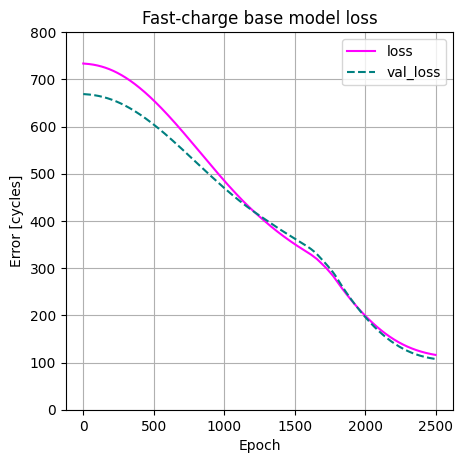

In [10]:
def plot_loss(history):
  plt.figure("Fast-charge base model loss", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.plot(history['RMSE'], label='loss', color='magenta')
  plt.plot(history['val_RMSE'], label='val_loss', color='teal', linestyle='--')
  plt.ylim([0, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.grid(True)
  plt.title('Fast-charge base model loss')
  plt.savefig(SAVED_RESULT_PATH + "/fastcharge_basemodel_loss_RUN#" + str(RUN_NUMBER) + ".png")
  

## Display model's loss and accuracy history
fastcharge_basemodel_history = pd.DataFrame(history.history)
fastcharge_basemodel_history.to_csv(SAVED_RESULT_PATH + "/fastcharge_basemodel_history_RUN#" + str(RUN_NUMBER) + ".csv")
plot_loss(fastcharge_basemodel_history)

In [11]:
test_results = {}
test_results['variance_fastcharge_basemodel'] = variance_fastcharge_basemodel.evaluate(
    fastcharge_test_features['QDiffLinVar'],
    test_labels, verbose=1) #sqrt for mse

1/1 [==============================] - 0s 21ms/step - loss: 11558.7061 - RMSE: 107.5114 - mae: 84.4768


### Make Predictions

1/1 [==============================] - 0s 19ms/step


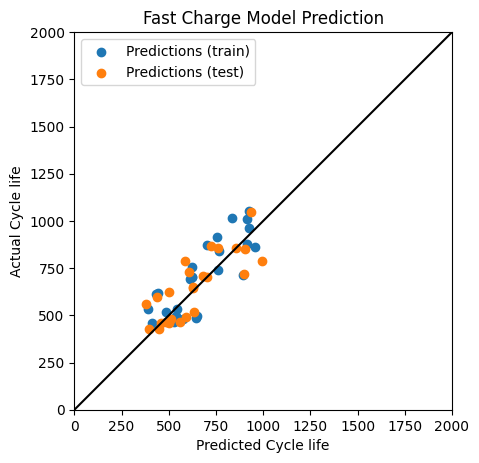

In [12]:
def plot_prediction(y_train, y_test):
  plt.figure("Fast-charge Base-model Prediction", figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.legend()
  plt.title('Fast Charge Model Prediction')
  plt.savefig( SAVED_RESULT_PATH + '/fastcharge_basemodel_prediction_RUN#' + str(RUN_NUMBER) + '.png')

train_prediction = variance_fastcharge_basemodel.predict(fast_charge_train_ds['QDiffLinVar'])
test_prediction = variance_fastcharge_basemodel.predict(fast_charge_test_ds['QDiffLinVar'])
plot_prediction(train_prediction, test_prediction)

### Final Results

In [13]:

result = pd.DataFrame(test_results, index=['MSE', 'RMSE', 'MAE']).T
result.to_csv( SAVED_RESULT_PATH + '/fastcharge_basemodel_result_RUN#' + str(RUN_NUMBER) + ".csv")

### Saving the model

In [14]:
variance_fastcharge_basemodel.save('../variance_model/saved_model/variance_fastcharge_basemodel')

INFO:tensorflow:Assets written to: ../variance_model/saved_model/variance_fastcharge_basemodel\assets
